# node2vec
---
[node2vec](http://snap.stanford.edu/node2vec/) for link prediction:
1. Perform train-test split
1. Train skip-gram model on random walks within training graph
2. Get node embeddings from skip-gram model
3. Create bootstrapped edge embeddings by taking the Hadamard product of node embeddings
4. Train a logistic regression classifier on these edge embeddings (possible edge --> edge score between 0-1)
5. Evaluate these edge embeddings on the validation and test edge sets

node2vec source code: https://github.com/aditya-grover/node2vec

## 1. Read in Graph Data

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sp
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import pickle

: 

In [82]:
EGO_USER = 107 # which ego network to look at

# Load pickled (adj, feat) tuple
network_dir = './fb-processed/{0}-adj-feat.pkl'.format(EGO_USER)
with open(network_dir, 'rb') as f:
    adj, features = pickle.load(f,encoding='latin1')
    
g = nx.Graph(adj) # re-create graph using node indices (0 to num_nodes-1)

<ipython-input-82-ca15781b74ac>:6: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  adj, features = pickle.load(f,encoding='latin1')


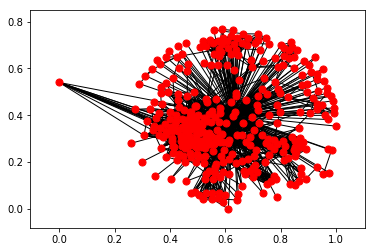

In [3]:
# draw network
nx.draw_networkx(g, with_labels=False, node_size=50, node_color='r')
plt.show()

## 2. Preprocessing/Train-Test Split

In [83]:
from gae.preprocessing import mask_test_edges
np.random.seed(0) # make sure train-test split is consistent between notebooks
adj_sparse = nx.to_scipy_sparse_array(g)

# Perform train-test split
adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj_sparse, test_frac=.3, val_frac=.1,verbose=True)
g_train = nx.from_scipy_sparse_array(adj_train) # new graph object with only non-hidden edges

preprocessing...
generating test/val sets...27794
generating test/val sets starting...


 40%|████      | 11128/27794 [08:07<12:10, 22.82it/s] 


creating false test edges...
creating false val edges...
creating false train edges...
final checks for disjointness...
creating adj_train...


/Users/mac/Documents/Teaching/Reaserach/Link predication/link-prediction-257604029069ba7baf6692e3839aa863bef22b06/gae/preprocessing.py:190: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_train = nx.adjacency_matrix(g)


Done with train-test split!


In [84]:
# Inspect train/test split
print ("Total nodes:", adj_sparse.shape[0])
print ("Total edges:", int(adj_sparse.nnz/2)) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print ("Training edges (positive):", len(train_edges))
print ("Training edges (negative):", len(train_edges_false))
print ("Validation edges (positive):", len(val_edges))
print ("Validation edges (negative):", len(val_edges_false))
print ("Test edges (positive):", len(test_edges))
print ("Test edges (negative):", len(test_edges_false))

Total nodes: 1046
Total edges: 27794
Training edges (positive): 16677
Training edges (negative): 16677
Validation edges (positive): 2779
Validation edges (negative): 2779
Test edges (positive): 8338
Test edges (negative): 8338


## 3. Train node2vec (Learn Node Embeddings)

In [7]:
from node2vec import Node2Vec
from gensim.models import Word2Vec

In [8]:
# node2vec settings
# NOTE: When p = q = 1, this is equivalent to DeepWalk

P = 1 # Return hyperparameter
Q = 1 # In-out hyperparameter

WINDOW_SIZE = 10 # Context size for optimization
NUM_WALKS = 10 # Number of walks per source
WALK_LENGTH = 80 # Length of walk per source
DIMENSIONS = 128 # Embedding dimension
DIRECTED = False # Graph directed/undirected
WORKERS = 8 # Num. parallel workers
ITER = 1 # SGD epochs

In [85]:

# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(g_train, dimensions=DIMENSIONS, walk_length=WALK_LENGTH, num_walks=NUM_WALKS, workers=4)  # Use temp_folder for big graphs

# Embed nodes
model = node2vec.fit(window=WINDOW_SIZE, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

emb_mappings = model.wv

Computing transition probabilities:   0%|          | 0/1046 [00:00<?, ?it/s]

In [18]:
# Preprocessing, generate walks
g_n2v = Node2Vec(g_train, DIRECTED, P, Q) # create node2vec graph instance
g_n2v.preprocess_transition_probs()
walks = g_n2v.simulate_walks(NUM_WALKS, WALK_LENGTH)
walks = [map(str, walk) for walk in walks]

# Train skip-gram model
model = Word2Vec(walks, size=DIMENSIONS, window=WINDOW_SIZE, min_count=0, sg=1, workers=WORKERS, iter=ITER)

# Store embeddings mapping
emb_mappings = model.wv

AttributeError: type object 'Node2Vec' has no attribute 'Graph'

## 4. Create Edge Embeddings

In [88]:
# Create node embeddings matrix (rows = nodes, columns = embedding features)
emb_list = []
for node_index in range(0, adj_sparse.shape[0]):
    node_str = str(node_index)
    node_emb = emb_mappings[node_str]
    emb_list.append(node_emb)
emb_matrix = np.vstack(emb_list)

In [89]:
# Generate bootstrapped edge embeddings (as is done in node2vec paper)
    # Edge embedding for (v1, v2) = hadamard product of node embeddings for v1, v2
def get_edge_embeddings(edge_list):
    embs = []
    for edge in edge_list:
        node1 = edge[0]
        node2 = edge[1]
        emb1 = emb_matrix[node1]
        emb2 = emb_matrix[node2]
        edge_emb = np.multiply(emb1, emb2)
        embs.append(edge_emb)
    embs = np.array(embs)
    return embs

In [90]:
# Train-set edge embeddings
pos_train_edge_embs = get_edge_embeddings(train_edges)
neg_train_edge_embs = get_edge_embeddings(train_edges_false)
train_edge_embs = np.concatenate([pos_train_edge_embs, neg_train_edge_embs])

# Create train-set edge labels: 1 = real edge, 0 = false edge
train_edge_labels = np.concatenate([np.ones(len(train_edges)), np.zeros(len(train_edges_false))])

# Val-set edge embeddings, labels
pos_val_edge_embs = get_edge_embeddings(val_edges)
neg_val_edge_embs = get_edge_embeddings(val_edges_false)
val_edge_embs = np.concatenate([pos_val_edge_embs, neg_val_edge_embs])
val_edge_labels = np.concatenate([np.ones(len(val_edges)), np.zeros(len(val_edges_false))])

# Test-set edge embeddings, labels
pos_test_edge_embs = get_edge_embeddings(test_edges)
neg_test_edge_embs = get_edge_embeddings(test_edges_false)
test_edge_embs = np.concatenate([pos_test_edge_embs, neg_test_edge_embs])

# Create val-set edge labels: 1 = real edge, 0 = false edge
test_edge_labels = np.concatenate([np.ones(len(test_edges)), np.zeros(len(test_edges_false))])

## 5. Evaluate Edge Embeddings

In [63]:
# Train logistic regression classifier on train-set edge embeddings
from sklearn.linear_model import LogisticRegression
edge_classifier = LogisticRegression(random_state=0)
edge_classifier.fit(train_edge_embs, train_edge_labels)

LogisticRegression(random_state=0)

In [75]:
from sklearn.neighbors import KNeighborsClassifier
edge_classifier = KNeighborsClassifier()
edge_classifier.fit(train_edge_embs, train_edge_labels)

KNeighborsClassifier()

In [64]:
# Predicted edge scores: probability of being of class "1" (real edge)
val_preds = edge_classifier.predict_proba(val_edge_embs)[:, 1]
val_roc = roc_auc_score(val_edge_labels, val_preds)
val_ap = average_precision_score(val_edge_labels, val_preds)

In [76]:
# Predicted edge scores: probability of being of class "1" (real edge)
test_preds = edge_classifier.predict_proba(test_edge_embs)[:, 1]
test_roc = roc_auc_score(test_edge_labels, test_preds)
test_ap = average_precision_score(test_edge_labels, test_preds)

In [77]:
print ('node2vec Validation ROC score: ', str(val_roc))
print ('node2vec Validation AP score: ', str(val_ap))
print ('node2vec Test ROC score: ', str(test_roc))
print ('node2vec Test AP score: ', str(test_ap))

node2vec Validation ROC score:  0.9320477502295685
node2vec Validation AP score:  0.9278969658336651
node2vec Test ROC score:  0.9474
node2vec Test AP score:  0.9205308561850607


In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score

In [78]:
test_preds[test_preds>=0.5]=1
test_preds[test_preds<0.5]=0
test_preds

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.])

In [79]:
import pandas as pd
lst_2= []
cm = confusion_matrix(test_edge_labels, test_preds)  #Confusion Matrix
accuracies = cross_val_score(estimator = edge_classifier, X = train_edge_embs, y = train_edge_labels, cv = 10)   #K-Fold Validation
roc = roc_auc_score(test_edge_labels, test_preds)  #ROC AUC Score
precision = precision_score(test_edge_labels, test_preds)  #Precision Score
recall = recall_score(test_edge_labels, test_preds)  #Recall Score
f1 = f1_score(test_edge_labels, test_preds)  #F1 Score


lst_2.append((accuracy_score(test_edge_labels, test_preds))*100) 
lst_2.append(accuracies.mean()*100)
lst_2.append(accuracies.std()*100)
lst_2.append(roc*100)
lst_2.append(precision*100)
lst_2.append(recall*100)
lst_2.append(f1*100)



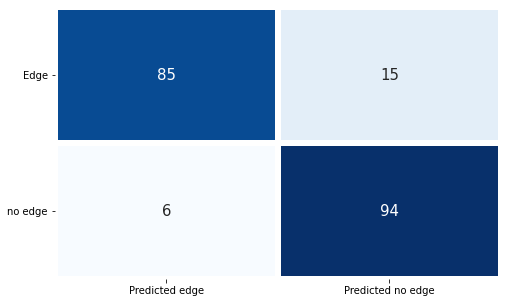

In [80]:
import seaborn as sns
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['Edge', 'no edge'], xticklabels = ['Predicted edge', 'Predicted no edge'])
plt.yticks(rotation = 0)
plt.show()

NameError: name 'list_2' is not defined

In [81]:
lst_2

[89.5,
 88.16463414634146,
 5.165929805514462,
 89.5,
 86.23853211009175,
 94.0,
 89.95215311004785]

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [95]:


models = []
models.append(['Logistic Regreesion', LogisticRegression(random_state=0)])
models.append(['SVM', SVC(random_state=0,probability=True)])
models.append(['KNeighbors', KNeighborsClassifier()])
models.append(['GaussianNB', GaussianNB()])
models.append(['BernoulliNB', BernoulliNB()])
models.append(['Decision Tree', DecisionTreeClassifier(random_state=0)])
models.append(['Random Forest', RandomForestClassifier(random_state=0)])
models.append(['XGBoost', XGBClassifier(eval_metric= 'error')])


In [106]:
lst_1= []
n=16671-100
for m in (range(len(models))):
    lst_2= []
    print(models[m][0])
    model = models[m][1]
    model.fit(train_edge_embs, train_edge_labels)
    test_preds = model.predict_proba(test_edge_embs)[:, 1]

    test_preds[test_preds>=0.5]=1
    test_preds[test_preds<0.5]=0
    

    
    
    
    cm = confusion_matrix(test_edge_labels, test_preds)  #Confusion Matrix
    accuracies = cross_val_score(estimator = model, X = train_edge_embs, y = train_edge_labels, cv = 10)   #K-Fold Validation
    roc = roc_auc_score(test_edge_labels, test_preds)  #ROC AUC Score
    precision = precision_score(test_edge_labels, test_preds)  #Precision Score
    recall = recall_score(test_edge_labels, test_preds)  #Recall Score
    f1 = f1_score(test_edge_labels, test_preds)  #F1 Score
 
    lst_2.append(models[m][0])
    lst_2.append((accuracy_score(test_edge_labels, test_preds))*100) 
    lst_2.append(accuracies.mean()*100)
    lst_2.append(accuracies.std()*100)
    lst_2.append(roc)
    lst_2.append(precision)
    lst_2.append(recall)
    lst_2.append(f1)
    lst_1.append(lst_2)

Logistic Regreesion
SVM
KNeighbors
GaussianNB
BernoulliNB
Decision Tree
Random Forest
XGBoost


In [105]:
df = pd.DataFrame(lst_1, columns= ['Model', 'Accuracy', 'K-Fold Mean Accuracy', 'Std. Deviation', 'ROC AUC', 'Precision', 'Recall', 'F1'])
df.sort_values(by= ['Accuracy', 'K-Fold Mean Accuracy'], inplace= True, ascending= False)
df

,Model,Accuracy,K-Fold Mean Accuracy,Std. Deviation,ROC AUC,Precision,Recall,F1
1,SVM,86.723435,86.0,7.000000,0.867234,0.871152,0.861957,0.866530
6,Random Forest,85.727992,91.5,5.500000,0.857280,0.846718,0.872511,0.859421
0,Logistic Regreesion,85.242264,86.0,6.244998,0.852423,0.822877,0.898177,0.858880
4,BernoulliNB,84.696570,89.0,6.633250,0.846966,0.854361,0.836532,0.845352
7,XGBoost,81.542336,89.5,5.678908,0.815423,0.800091,0.840969,0.820021
3,GaussianNB,78.154234,84.5,6.500000,0.781542,0.810639,0.734709,0.770808
5,Decision Tree,70.532502,77.0,12.688578,0.705325,0.691627,0.741065,0.715493
2,KNeighbors,60.638043,62.0,5.099020,0.606380,0.559949,0.993644,0.716262


In [102]:
train_edge_labels

array([1., 1., 1., ..., 0., 0., 0.])